# **Skin Cancer Classification CNN Analysis**

##**Importing the Libraries Required**

In [ ]:
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pyarrow.parquet as pq
import pandas as pd
import io
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##**Setting Library Seeds for Reproducibility**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(464)

##**Preparing the Dataset**

In [ ]:
!unzip -oq /content/drive/MyDrive/cancer_dataset.zip

##**Implementing a Custom Dataset**



In [ ]:
class CancerDataset(Dataset):
    def __init__(self, parquet_file):
        """
        Args:
            parquet_file (str): Path to the Parquet file containing the dataset.
                                The dataset should have two columns: 'bytes' (image data) and 'label'.
        """
        data = pd.read_parquet(parquet_file).values

        self.image_bytes_list = [
            entry[0]["bytes"] if isinstance(entry[0], dict) else entry[0]
            for entry in data
        ]
        self.class_list = [entry[1] for entry in data]

        self.transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    def __len__(self):
        return len(self.image_bytes_list)

    def __getitem__(self, data_id):
        """
        Fetches the image and label for a given index.
        """
        image_bytes = self.image_bytes_list[data_id]
        image_class = self.class_list[data_id]

        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image_tensor = self.transform(image)

        return image_class, image_tensor

In [ ]:
train_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_train_2.parquet")
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_ratio = 0.125
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
val_dataloader = DataLoader(val_subset, batch_size=128, shuffle=False)

test_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_test.parquet")
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

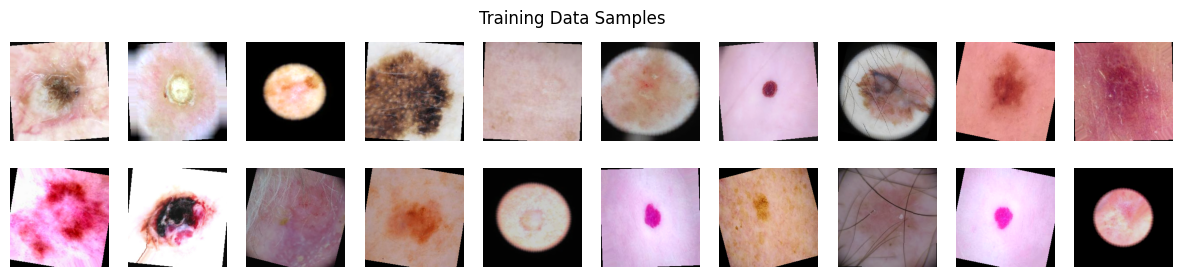

In [ ]:
_, images = next(iter(train_dataloader))
images = images.numpy()

num_rows = 2
num_columns = 10

figure, axis_array = plt.subplots(
    num_rows, num_columns, figsize=(num_columns * 1.5, num_rows * 1.5)
)
figure.suptitle("Training Data Samples")

im_id = 0
for row_id in range(num_rows):
    for column_id in range(num_columns):
        # The channel dimension of the image is moved to the last index
        # to make the shape of the image compatible with Matplotlib
        image = images[im_id].transpose(1, 2, 0)
        # Value range is mapped from [-1,1] to [0,1]
        image = (image + 1) / 2
        if num_rows == 1:
            current_axis = axis_array[column_id]
        else:
            current_axis = axis_array[row_id, column_id]
        current_axis.axis("off")
        current_axis.imshow(image)
        im_id += 1

##**Constructing a Classifier Network**

In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x112x112
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x56x56
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x28x28
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x14x14
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=64),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=64, out_features=8),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)

        return x

##**Implementing the Training Loop**


In [ ]:
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

best_val_loss = float("inf")
patience_counter = 0
patience_limit = 8

##**Evaluating the Model**

In [ ]:
def display_evaluation_metrics():
    model.eval()

    pred_class_list = []
    gt_class_list = []

    with torch.no_grad():
        for batch_image_class, batch_image_tensor in test_dataloader:
            if torch.cuda.is_available():
                batch_image_tensor = batch_image_tensor.cuda()
                batch_image_class = batch_image_class.cuda()

            batch_outputs = model(batch_image_tensor)

            batch_image_class = batch_image_class.cpu().numpy()
            batch_outputs = batch_outputs.cpu().numpy()
            pred_classes = np.argmax(batch_outputs, axis=1)

            pred_class_list.extend(pred_classes)
            gt_class_list.extend(batch_image_class)

    accuracy = accuracy_score(gt_class_list, pred_class_list)
    print(f"Accuracy: {accuracy:.4f}")

    print(classification_report(gt_class_list, pred_class_list))

    cm = confusion_matrix(gt_class_list, pred_class_list)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/400 - Train Loss: 1.7009 - Val Loss: 1.5142 - LR: 0.000200
Accuracy: 0.4229
              precision    recall  f1-score   support

           0       0.36      0.32      0.34       524
           1       0.38      0.44      0.40       524
           2       0.31      0.45      0.37       524
           3       0.64      0.15      0.24       524
           4       0.39      0.38      0.39       524
           5       0.49      0.51      0.50       524
           6       0.31      0.38      0.34       524
           7       0.73      0.76      0.74       524

    accuracy                           0.42      4192
   macro avg       0.45      0.42      0.42      4192
weighted avg       0.45      0.42      0.42      4192



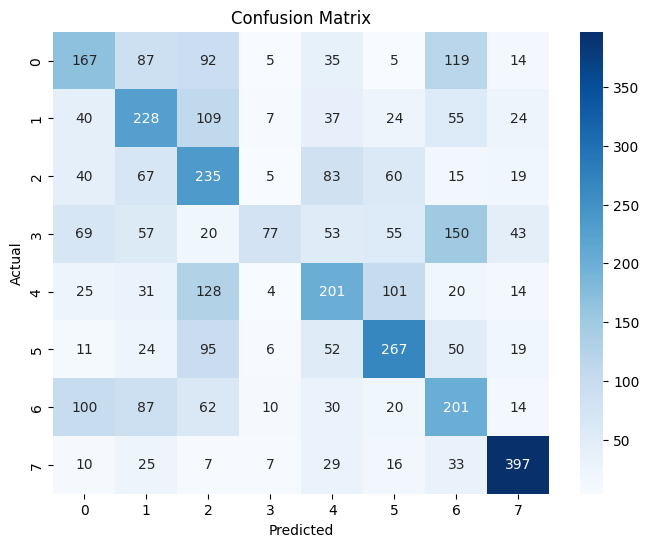

Epoch 2/400 - Train Loss: 1.4711 - Val Loss: 1.4697 - LR: 0.000200
Epoch 3/400 - Train Loss: 1.3872 - Val Loss: 1.3314 - LR: 0.000200
Epoch 4/400 - Train Loss: 1.3199 - Val Loss: 1.2893 - LR: 0.000200
Epoch 5/400 - Train Loss: 1.2586 - Val Loss: 1.2205 - LR: 0.000200
Epoch 6/400 - Train Loss: 1.2165 - Val Loss: 1.2266 - LR: 0.000200
No improvement for 1 epochs.
Epoch 7/400 - Train Loss: 1.1742 - Val Loss: 1.1472 - LR: 0.000200
Epoch 8/400 - Train Loss: 1.1494 - Val Loss: 1.1516 - LR: 0.000200
No improvement for 1 epochs.
Epoch 9/400 - Train Loss: 1.1079 - Val Loss: 1.1023 - LR: 0.000200
Epoch 10/400 - Train Loss: 1.0928 - Val Loss: 1.0856 - LR: 0.000200
Epoch 11/400 - Train Loss: 1.0639 - Val Loss: 1.0624 - LR: 0.000200
Accuracy: 0.5646
              precision    recall  f1-score   support

           0       0.47      0.59      0.52       524
           1       0.48      0.51      0.49       524
           2       0.46      0.37      0.41       524
           3       0.56      0.77   

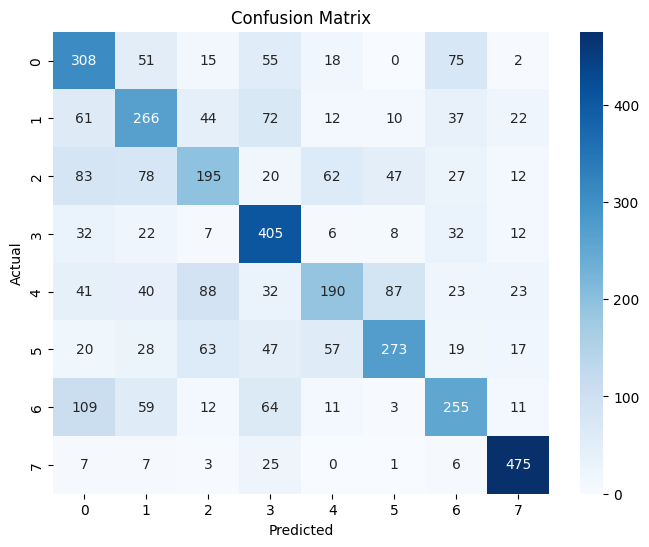

Epoch 12/400 - Train Loss: 1.0241 - Val Loss: 1.0064 - LR: 0.000200
Epoch 13/400 - Train Loss: 1.0067 - Val Loss: 1.0556 - LR: 0.000200
No improvement for 1 epochs.
Epoch 14/400 - Train Loss: 0.9952 - Val Loss: 0.9327 - LR: 0.000200
Epoch 15/400 - Train Loss: 0.9636 - Val Loss: 0.9313 - LR: 0.000200
Epoch 16/400 - Train Loss: 0.9495 - Val Loss: 0.9636 - LR: 0.000200
No improvement for 1 epochs.
Epoch 17/400 - Train Loss: 0.9422 - Val Loss: 0.9532 - LR: 0.000200
No improvement for 2 epochs.
Epoch 18/400 - Train Loss: 0.9245 - Val Loss: 0.9666 - LR: 0.000200
No improvement for 3 epochs.
Epoch 19/400 - Train Loss: 0.9000 - Val Loss: 0.9019 - LR: 0.000200
Epoch 20/400 - Train Loss: 0.8827 - Val Loss: 0.8805 - LR: 0.000200
Epoch 21/400 - Train Loss: 0.8688 - Val Loss: 0.8784 - LR: 0.000200
Accuracy: 0.6078
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       524
           1       0.54      0.59      0.56       524
           2       0.51 

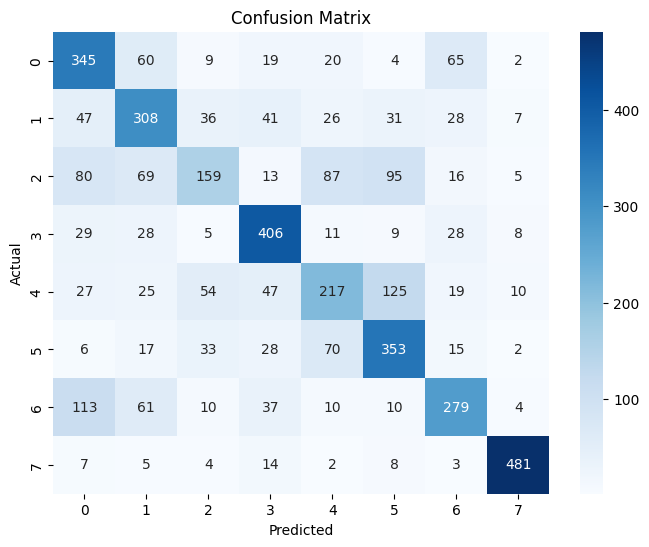

Epoch 22/400 - Train Loss: 0.8683 - Val Loss: 0.8294 - LR: 0.000200
Epoch 23/400 - Train Loss: 0.8446 - Val Loss: 0.8392 - LR: 0.000200
No improvement for 1 epochs.
Epoch 24/400 - Train Loss: 0.8333 - Val Loss: 0.8217 - LR: 0.000200
Epoch 25/400 - Train Loss: 0.8098 - Val Loss: 0.8030 - LR: 0.000200
Epoch 26/400 - Train Loss: 0.8061 - Val Loss: 0.8122 - LR: 0.000200
No improvement for 1 epochs.
Epoch 27/400 - Train Loss: 0.7883 - Val Loss: 0.7975 - LR: 0.000200
Epoch 28/400 - Train Loss: 0.7649 - Val Loss: 0.7968 - LR: 0.000200
Epoch 29/400 - Train Loss: 0.7796 - Val Loss: 0.7794 - LR: 0.000200
Epoch 30/400 - Train Loss: 0.7588 - Val Loss: 0.7388 - LR: 0.000200
Epoch 31/400 - Train Loss: 0.7408 - Val Loss: 0.7234 - LR: 0.000200
Accuracy: 0.6128
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       524
           1       0.53      0.63      0.57       524
           2       0.42      0.53      0.47       524
           3       0.73     

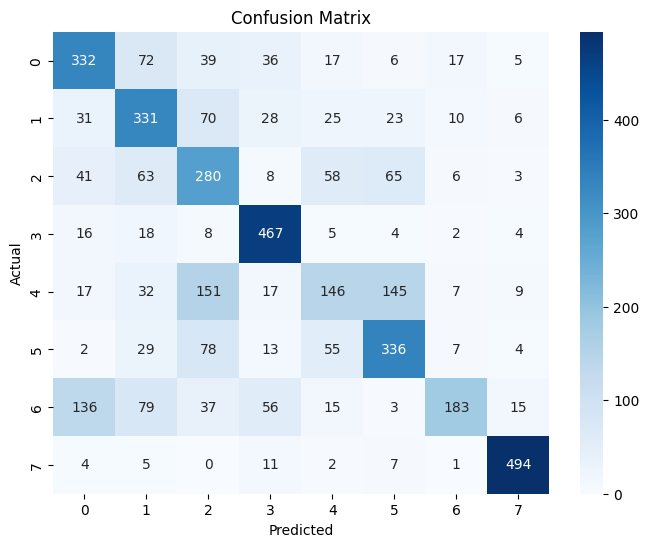

Epoch 32/400 - Train Loss: 0.7167 - Val Loss: 0.7323 - LR: 0.000200
No improvement for 1 epochs.
Epoch 33/400 - Train Loss: 0.7220 - Val Loss: 0.7242 - LR: 0.000200
No improvement for 2 epochs.
Epoch 34/400 - Train Loss: 0.7116 - Val Loss: 0.7785 - LR: 0.000200
No improvement for 3 epochs.
Epoch 35/400 - Train Loss: 0.6968 - Val Loss: 0.6836 - LR: 0.000200
Epoch 36/400 - Train Loss: 0.6819 - Val Loss: 0.7456 - LR: 0.000200
No improvement for 1 epochs.
Epoch 37/400 - Train Loss: 0.6734 - Val Loss: 0.6922 - LR: 0.000200
No improvement for 2 epochs.
Epoch 38/400 - Train Loss: 0.6609 - Val Loss: 0.6466 - LR: 0.000200
Epoch 39/400 - Train Loss: 0.6460 - Val Loss: 0.6979 - LR: 0.000200
No improvement for 1 epochs.
Epoch 40/400 - Train Loss: 0.6456 - Val Loss: 0.6638 - LR: 0.000200
No improvement for 2 epochs.
Epoch 41/400 - Train Loss: 0.6258 - Val Loss: 0.6266 - LR: 0.000200
Accuracy: 0.6481
              precision    recall  f1-score   support

           0       0.69      0.44      0.54  

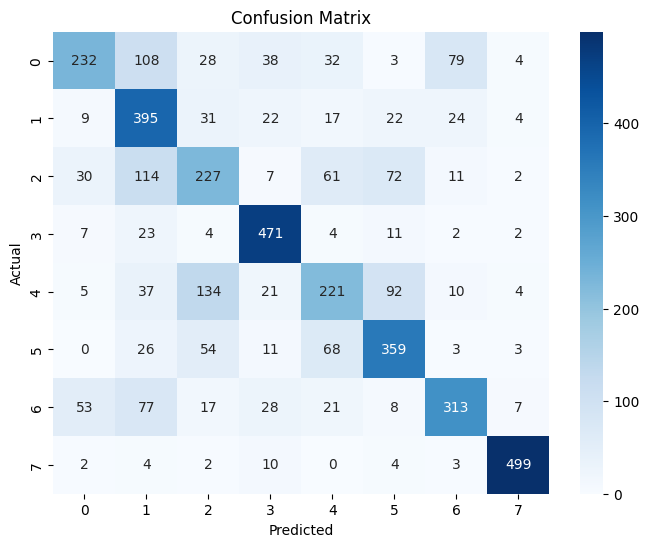

Epoch 42/400 - Train Loss: 0.6202 - Val Loss: 0.6274 - LR: 0.000200
No improvement for 1 epochs.
Epoch 43/400 - Train Loss: 0.6147 - Val Loss: 0.5783 - LR: 0.000200
Epoch 44/400 - Train Loss: 0.6129 - Val Loss: 0.6191 - LR: 0.000200
No improvement for 1 epochs.
Epoch 45/400 - Train Loss: 0.5953 - Val Loss: 0.5976 - LR: 0.000200
No improvement for 2 epochs.
Epoch 46/400 - Train Loss: 0.5920 - Val Loss: 0.5790 - LR: 0.000200
No improvement for 3 epochs.
Epoch 47/400 - Train Loss: 0.5734 - Val Loss: 0.5614 - LR: 0.000200
Epoch 48/400 - Train Loss: 0.5629 - Val Loss: 0.5633 - LR: 0.000200
No improvement for 1 epochs.
Epoch 49/400 - Train Loss: 0.5736 - Val Loss: 0.5553 - LR: 0.000200
Epoch 50/400 - Train Loss: 0.5436 - Val Loss: 0.5632 - LR: 0.000200
No improvement for 1 epochs.
Epoch 51/400 - Train Loss: 0.5392 - Val Loss: 0.5120 - LR: 0.000200
Accuracy: 0.6644
              precision    recall  f1-score   support

           0       0.71      0.54      0.61       524
           1       0

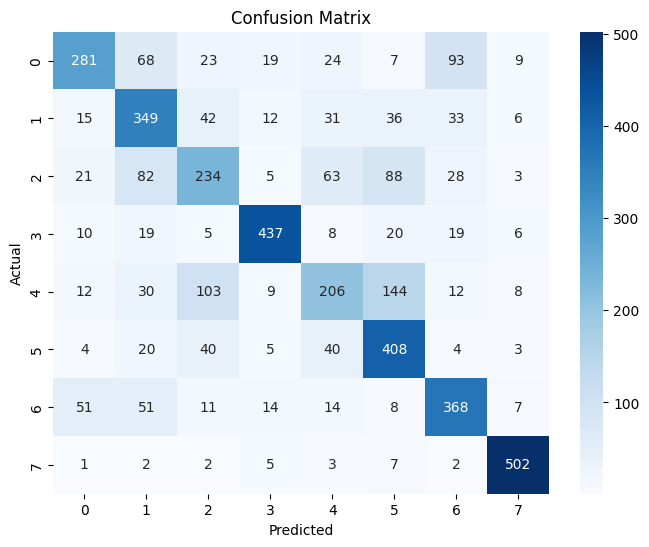

In [ ]:
num_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_epochs = 400

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_image_class, batch_image_tensor in train_dataloader:
        batch_image_tensor, batch_image_class = batch_image_tensor.to(
            device
        ), batch_image_class.to(device)

        optimizer.zero_grad()
        outputs = model(batch_image_tensor)
        loss = loss_func(outputs, batch_image_class)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_image_class, val_image_tensor in val_dataloader:
            val_image_tensor, val_image_class = val_image_tensor.to(
                device
            ), val_image_class.to(device)
            val_outputs = model(val_image_tensor)
            val_loss = loss_func(val_outputs, val_image_class)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / num_val_batches
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    current_lr = scheduler.get_last_lr()[0]
    print(
        f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - LR: {current_lr:.6f}"
    )

    if epoch % 10 == 0:
        display_evaluation_metrics()

    # Early stopping rule
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience_limit:
        num_epochs = epoch
        print("Early stopping triggered. Terminating training.")
        break

##**Plotting the Training Loss Curves**

In [ ]:
plt.plot(
    range(1, num_epochs + 1),
    train_losses,
    label="Train Loss",
    color="tab:blue",
    linewidth=2,
)
plt.plot(
    range(1, num_epochs + 1),
    val_losses,
    label="Validation Loss",
    color="tab:orange",
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()